## **Machine Learning Project**

Import Necessary Libraries

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib
import sys

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2

# Additional libraries
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import psutil
import os
from tensorflow.keras.utils import plot_model

# For models
from keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D, Flatten, Dropout,  BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# For model evaluation:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
#Print out versions
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Python version:", sys.version)

Numpy version: 1.25.2
Pandas version: 2.0.3
TensorFlow version: 2.15.0
Keras version: 2.15.0
OpenCV version: 4.8.0
Matplotlib version: 3.7.1
Seaborn version: 0.13.1
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


### **Prepare Dataset**

Mount the dataset by the following code (Requires authorization) - For Josiah

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project"

tumordataset_zip = os.path.join(data_path, 'braintumor_dataset.zip')
segmentation_zip = os.path.join(data_path, 'segmentation_dataset.zip')

training_path = "Training"
testing_path = "Testing"
print(tumordataset_zip)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/braintumor_dataset.zip


Mount the dataset by the following code (Requires authorization) - For Natcha

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/COMP4211 Project"

tumordataset_zip = os.path.join(data_path, 'braintumor_dataset.zip')

training_path = "Training"
testing_path = "Testing"
print(tumordataset_zip)

Mounted at /content/drive
/content/drive/My Drive/COMP4211 Project/braintumor_dataset.zip


Unzip the dataset to the Google Colab VM rather than access it directly from Google Drive

In [ ]:
!unzip "$tumordataset_zip" > /dev/null 2>&1
!unzip "$segmentation_zip" > /dev/null 2>&1

Helper Functions

In [ ]:
# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path):
    image_paths = []
    image_labels = []

    for label in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, label)
        for filename in os.listdir(folder_path):
          file_path = os.path.join(folder_path, filename)
          image_paths.append(file_path)
          image_labels.append(label)

    return image_paths, image_labels

# Loads an image from disk in rgb format, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(150,150)):
    image = cv2.imread(img_path)
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    return image

# Loads an image from disk in greyscale format, optionally resize it, and prepares it for the model
def get_greyscaled_image(image_path, resize=True, shape=(150,150)):
    image = cv2.imread(image_path, 0)
    print(image.shape)
    if resize:
      image = cv2.resize(image, shape)
    return image

# Show the metrics for accuracy, precision, recall, F1-score and confustion matrix
def show_metrics(class_labels, true_labels, predicted_labels):
  accuracy = accuracy_score(true_labels, predicted_labels)

  print("accuracy: " + str(accuracy))

  # Calculate precision, recall, and F1-score
  precision = precision_score(true_labels, predicted_labels, average='macro')
  recall = recall_score(true_labels, predicted_labels, average='macro')
  f1 = f1_score(true_labels, predicted_labels, average='macro')

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)


  # Generate confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Create a heatmap of the confusion matrix
  sns.heatmap(cm, annot=True, cmap='Blues')

  # Set the axis labels
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')

  plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45)
  plt.yticks(ticks = np.arange(len(class_labels))+0.5, labels = class_labels, rotation=0, va='center')

  # Set the title
  plt.title('Confusion Matrix')

  # Show the plot
  plt.show()


# Show the statistics of model predicting the testing set
def predict_testing_set(load_path: str):

  model1 = load_model(load_path)

  images, label = braintumor_test_ds.get_images()

  class_labels = braintumor_test_ds.classes


  predictions = model1.predict(images)

  predicted_labels = np.argmax(predictions, axis=1)

  true_labels = np.argmax(label, axis=1)

  show_mislabeled_images(images, true_labels, predicted_labels, class_labels, 4)

  show_metrics(class_labels, true_labels, predicted_labels)


def show_mislabeled_images(images, true_labels, predicted_labels, class_labels, num_images=4):
    mislabeled_images = []
    mislabeled_true_labels = []
    mislabeled_predicted_labels = []

    for i in range(len(images)):
        if true_labels[i] != predicted_labels[i]:
            mislabeled_images.append(images[i])
            mislabeled_true_labels.append(true_labels[i])
            mislabeled_predicted_labels.append(predicted_labels[i])

        if len(mislabeled_images) >= num_images:
            break

    num_rows = (num_images + 3) // 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))

    for i, (image, true_label, predicted_label) in enumerate(zip(mislabeled_images, mislabeled_true_labels, mislabeled_predicted_labels)):
        row = i // 4
        col = i % 4
        if num_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
        ax.imshow(image.astype(np.uint8), cmap="gray")
        ax.set_title(f"True Label: {class_labels[true_label]}\nPredicted Label: {class_labels[predicted_label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()



Implements a class to handle Training and Testing Dataset

In [ ]:
class ClassificationDataset:
  def __init__(self, dir_path, batch_size=8, random_state=4211):
    self.dir_path = dir_path
    self.classes = []
    self.data_table = self._process_data(dir_path)
    self.random_sate = random_state
    self.ds_pointer = 0
    self.batch_size = batch_size

  def _process_data(self, dir_path):
    image_path, image_labels = find_images(dir_path)

    # Shuffle the data (Not sure whether to do this, can comment out) because it is
    combined_data = list(zip(image_path, image_labels))
    random.seed(4211)
    random.shuffle(combined_data)

    image_path, image_labels = zip(*combined_data)
    data = pd.DataFrame({'Image_path': image_path, 'Label': image_labels})
    # Perform one Hot Encoding
    encoder = OneHotEncoder(sparse = False)
    labels = np.array(data["Label"]).reshape(-1,1)
    one_hot_labels = encoder.fit_transform (labels)

    # Retrieve the classes from the encoder
    self.classes = encoder.categories_[0].tolist()
    class_df = pd.DataFrame(one_hot_labels, columns=self.classes)

    # Concatenate the original data table and the one-hot encoded columns
    data_table = pd.concat([data, class_df], axis=1)
    return data_table

  def get_images(self):
    images = []
    labels = []
    for i in range(len(self.data_table)):
      image_path = self.data_table.iloc[i]['Image_path']
      label = self.data_table.iloc[i][self.classes].values
      image = get_image(image_path)
      images.append(image)
      labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

  def get_greyscaled_images(self):
    images = []
    labels = []
    for i in range(len(self.data_table)):
      image_path = self.data_table.iloc[i]['Image_path']
      label = self.data_table.iloc[i][self.classes].values
      image = get_greyscaled_image(image_path)
      images.append(image)
      labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)



In [ ]:
braintumor_train_ds= ClassificationDataset(training_path)
braintumor_test_ds = ClassificationDataset(testing_path)
print(braintumor_train_ds.classes)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### **Visualization on the Dataset**

a) Sample Image from Each Label

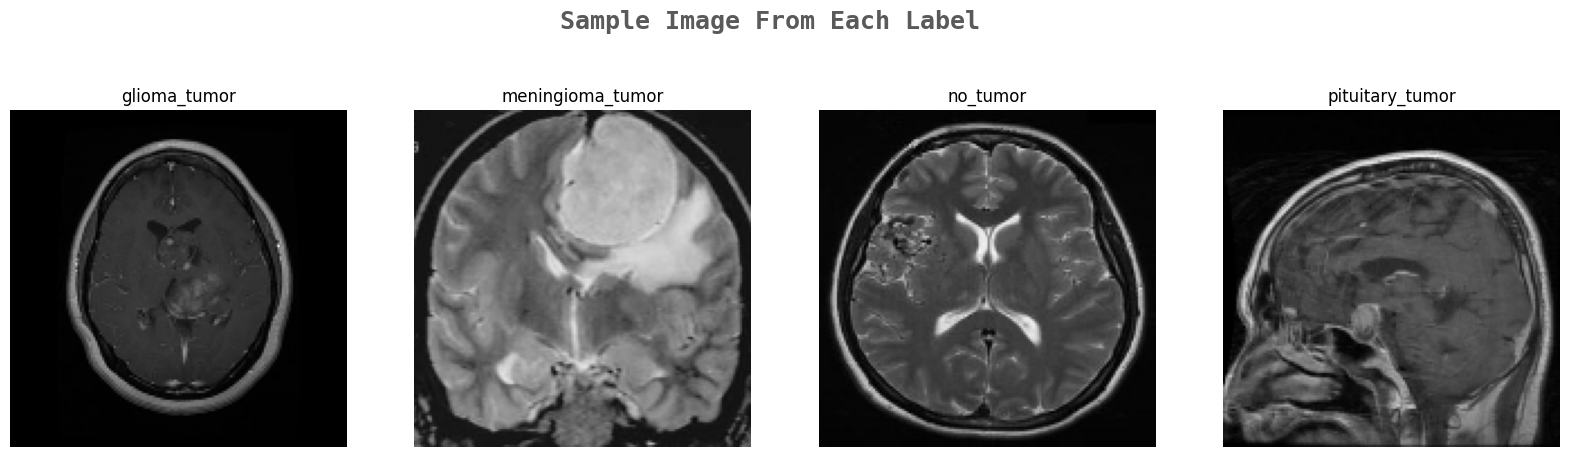

In [ ]:
def show_samples():
  k=0
  fig, ax = plt.subplots(1,4,figsize=(20,20))
  fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
              fontname='monospace',color="#313131",y=0.62,x=0.4,alpha=0.8)
  for i in range(len(braintumor_train_ds.classes)):
      j=0
      while True :
          if braintumor_train_ds.data_table.iloc[j]['Label']== braintumor_train_ds.classes[i]:
              ax[k].imshow(get_image(braintumor_train_ds.data_table.iloc[j]['Image_path']))
              ax[k].set_title(braintumor_train_ds.classes[i])
              ax[k].axis('off')
              k+=1
              break
          j+=1
show_samples()

b) Number of Images of each label from training and testing dataset

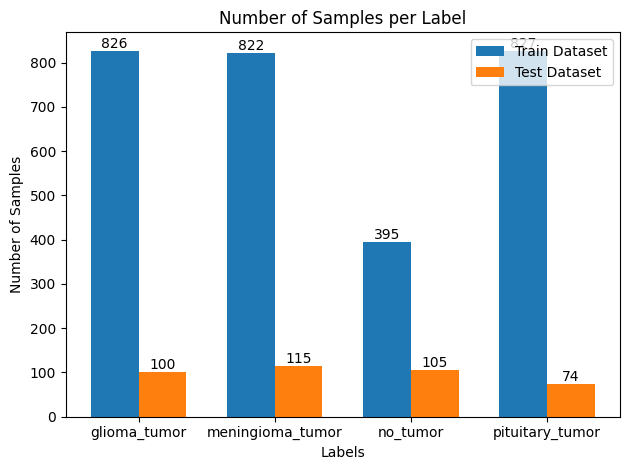

In [ ]:
def show_count():
    train_labels = braintumor_train_ds.data_table['Label']
    test_labels = braintumor_test_ds.data_table['Label']

    # Count occurrences of each label in train and test datasets
    train_label_counts = train_labels.value_counts().sort_index()
    test_label_counts = test_labels.value_counts().sort_index()

    train_labels = train_label_counts.index
    train_counts = train_label_counts.values

    test_labels = test_label_counts.index
    test_counts = test_label_counts.values

    # Set the configurations of the plots
    bar_width = 0.35

    fig, ax = plt.subplots()

    train_positions = np.arange(len(train_labels))
    test_positions = train_positions + bar_width

    ax.bar(train_positions, train_counts, width=bar_width, label='Train Dataset')

    ax.bar(test_positions, test_counts, width=bar_width, label='Test Dataset')

    for i, count in enumerate(train_counts):
        ax.text(train_positions[i], count, str(count), ha='center', va='bottom')

    for i, count in enumerate(test_counts):
        ax.text(test_positions[i], count, str(count), ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Number of Samples per Label')

    ax.set_xticks(train_positions + bar_width / 2)
    ax.set_xticklabels(train_labels)

    # Set the legends
    ax.legend()

    plt.tight_layout()

    # Display the plot
    plt.show()

show_count()

# Task #1: Classification

## **Baseline Model: CNN with Raw Images**



<h3> Build Baseline CNN Model Architecture

In [ ]:
def cnn_model(input_shape, num_classes):
    model = keras.Sequential(
        [
            #Convolutional network with increasing filters
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),

            Conv2D(64, (3, 3), activation='relu'),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),

            Conv2D(128, (3, 3), activation='relu'),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),

            Conv2D(256, (3, 3), activation='relu'),
            Conv2D(256, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),

            # Flatten the 2D features to 1D
            Flatten(),

            # Fully connected layers with dropouts
            Dense(512, activation='relu'),
            Dropout(0.5),

            Dense(256, activation='relu'),
            Dropout(0.5),

            #Final dense with softmax to get probability
            Dense(units=num_classes, activation='softmax')
        ]
    )

    return model


In [ ]:
def model_setup(LOAD_PATH=None):
  INPUT_SHAPE = (150, 150, 3)
  NUM_CLASSES = len(braintumor_train_ds.classes)

  # Build model
  model = cnn_model(INPUT_SHAPE, NUM_CLASSES)

  # Use categorical cross entropy loss
  loss_fn = tf.keras.losses.CategoricalCrossentropy()

  if LOAD_PATH:
      model.load_weights(LOAD_PATH)

  return model, loss_fn


In [ ]:
def model_train(model, x_train, y_train , loss_fn, num_epochs, save_interval=1, save_path=None, load_path=None):
    #Use adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)

    if load_path:
        model.load_weights(load_path)

    callbacks = []
    if save_path:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_freq=save_interval))

    model.compile(optimizer=optimizer, loss=loss_fn)

    model.fit(x_train, y_train, epochs=num_epochs, callbacks=callbacks)


<h3> Set up Model and Loss Function </h3>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                   

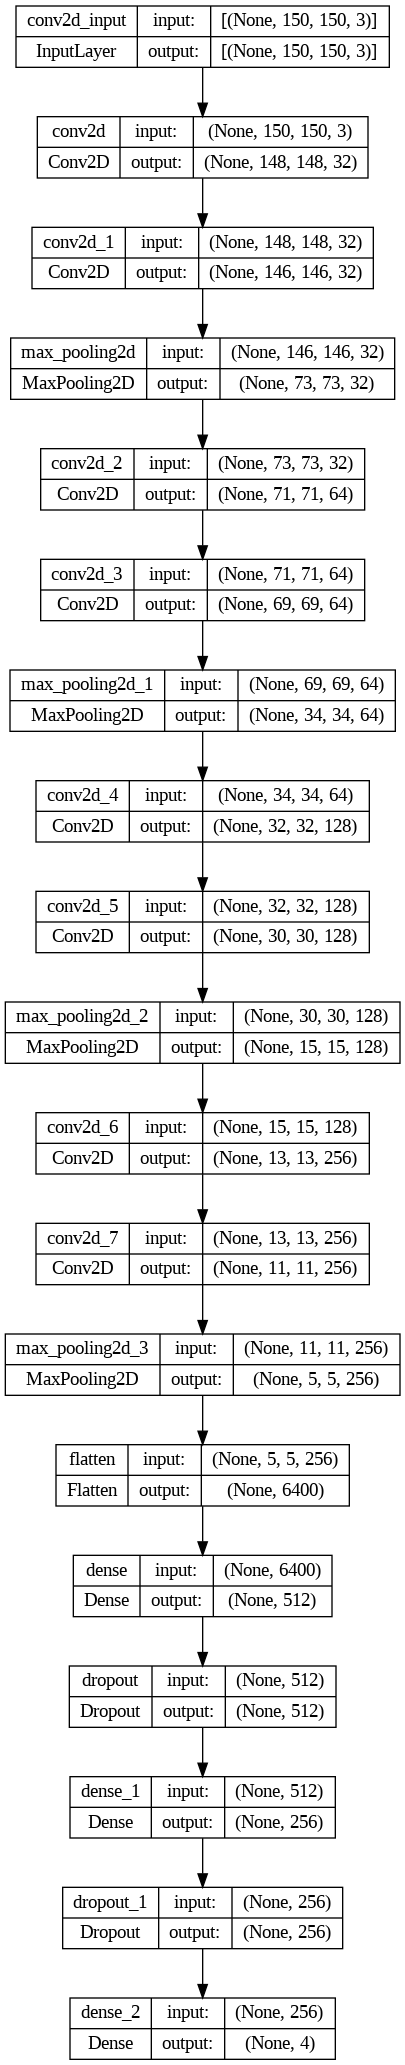

In [ ]:
baseline_model_raw, loss = model_setup()

# Print model summary and model plot
baseline_model_raw.summary()

plot_model(baseline_model_raw, to_file='/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/model1.png', show_shapes=True)


In [ ]:
# Change it to your own PATH

# Natcha Save Path
# BASELINE_MODEL_RAW_SAVE_PATH = "/content/drive/MyDrive/baseline_model_raw.h5"
# BASELINE_MODEL_RAW_LOAD_PATH = "/content/drive/MyDrive/baseline_model_raw.h5"


# # Josiah Save Path
BASELINE_MODEL_RAW_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_raw.h5"
BASELINE_MODEL_RAW_LOAD_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_raw.h5"



x_train, y_train = braintumor_train_ds.get_images()

#Train with 30 epochs
model_train(baseline_model_raw, x_train, y_train, loss, num_epochs=30, save_path=BASELINE_MODEL_RAW_SAVE_PATH, save_interval=1, load_path=None)



Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 40s 364ms/step - loss: 1.3105
Epoch 2/30
90/90 [==============================] - 31s 343ms/step - loss: 0.9899
Epoch 3/30
90/90 [==============================] - 33s 368ms/step - loss: 0.8483
Epoch 4/30
90/90 [==============================] - 31s 350ms/step - loss: 0.7366
Epoch 5/30
90/90 [==============================] - 30s 332ms/step - loss: 0.5792
Epoch 6/30
90/90 [==============================] - 33s 352ms/step - loss: 0.4993
Epoch 7/30
90/90 [==============================] - 32s 355ms/step - loss: 0.4253
Epoch 8/30
90/90 [==============================] - 30s 336ms/step - loss: 0.3466
Epoch 9/30
90/90 [==============================] - 32s 352ms/step - loss: 0.2923
Epoch 10/30
90/90 [==============================] - 32s 353ms/step - loss: 0.2794
Epoch 11/30
90/90 [==============================] - 31s 347ms/step - loss: 0.2164
Epoch 12/30
90/90 [==============================] - 31s 345ms/step - loss: 0.1843
Epoch 13/30
90/90 [=====

<h3> Save the Model </h3>

In [ ]:
# Change it to your own PATH

#baseline_model_raw.save("/content/drive/MyDrive/baseline_model_raw.h5")
baseline_model_raw.save("/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_raw.h5")

<h3> Predict Testing Set (Baseline CNN Model: Raw Images)

13/13 [==============================] - 0s 6ms/step


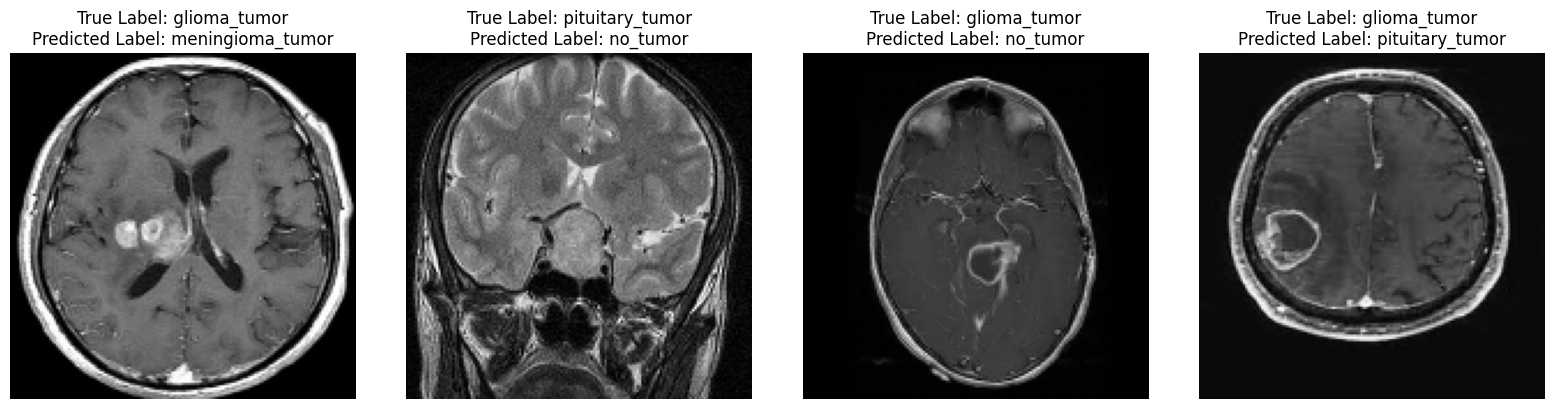

accuracy: 0.7258883248730964
Precision: 0.7789655923131868
Recall: 0.7131844888366627
F1-score: 0.6779485998905121


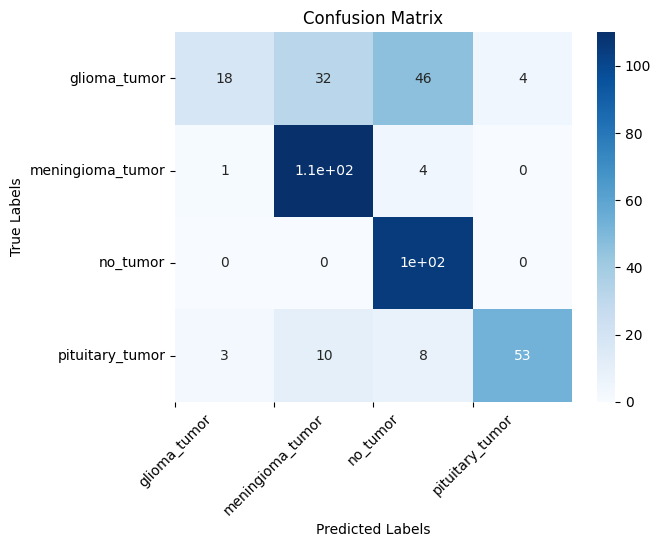

In [ ]:
# Change it to your own PATH

# predict_training_set("/content/drive/MyDrive/baseline_model_raw.h5")
predict_testing_set("/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_raw.h5")




## **Baseline Model: CNN with Data Augmentation**



<h3> Perform data augmentation to increase size of dataset </h4>

In [ ]:
x_train, y_train = braintumor_train_ds.get_images()

In [ ]:
# Train with the same CNN model
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by 20 degrees
    shear_range=0.2,        # Apply random shear transformations
    zoom_range=0.2,         # Apply random zoom transformations
    horizontal_flip=True,   # Randomly flip images horizontally
)

augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    image, label = datagen.flow(x=x_train[i:i+1], y=y_train[i:i+1], shuffle=False, batch_size=1).next()
    augmented_images.append(image[0])
    augmented_labels.append(label[0])

augmented_train_images = np.concatenate((x_train, augmented_images), axis=0)
augmented_train_labels = np.concatenate((y_train, augmented_labels), axis=0)
print(augmented_train_images.shape)


(5740, 150, 150, 3)


In [ ]:
#Reduce the datasize for the ResNet Model
total_samples = augmented_train_images.shape[0]
shuffled_indices = np.random.permutation(total_samples)
shuffled_augmented_train_images = augmented_train_images[shuffled_indices]
shuffled_augmented_train_labels = augmented_train_labels[shuffled_indices]
half_samples = total_samples // 2
new_augmented_train_images = shuffled_augmented_train_images[:half_samples]
new_augmented_train_labels = shuffled_augmented_train_labels[:half_samples]


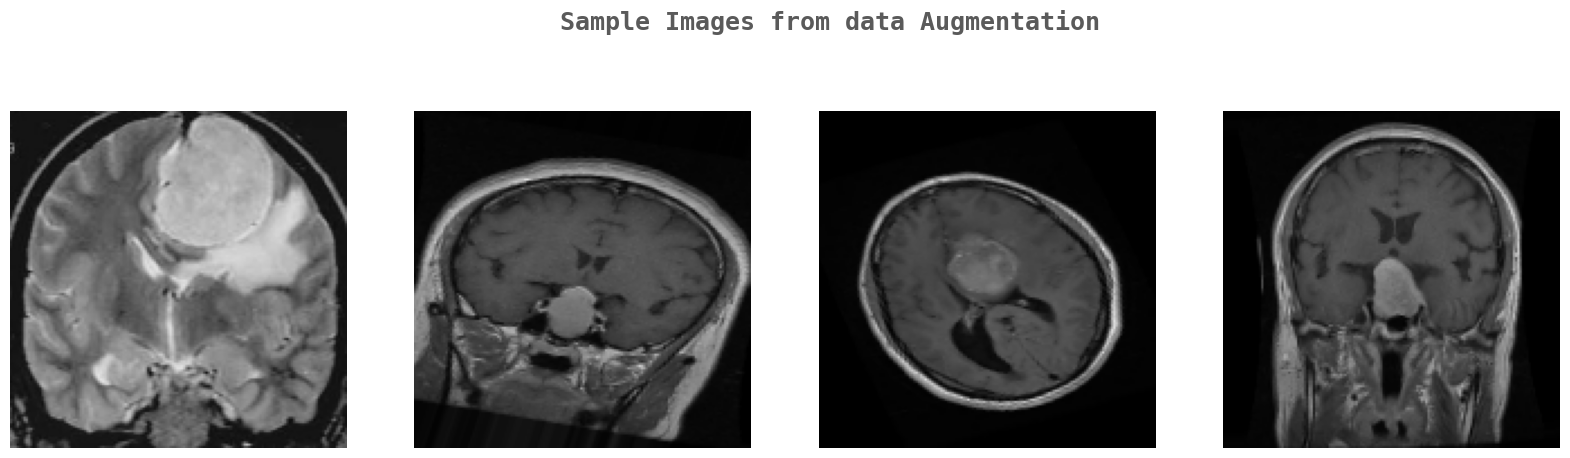

In [ ]:
#Show augmented data examples
def show_samples():
  fig, ax = plt.subplots(1,4,figsize=(20,20))
  fig.text(s='Sample Images from data Augmentation',size=18,fontweight='bold',
              fontname='monospace',color="#313131",y=0.62,x=0.4,alpha=0.8)
  for i in range(0, 4):
      image = augmented_train_images[-(0 + i)]
      ax[i].imshow(image.astype('uint8'))
      ax[i].axis('off')
show_samples()

In [ ]:
baseline_model_augmented, loss = model_setup()


In [ ]:
# Change it to your own PATH

baseline_model_augmented, loss = model_setup()
epochs = 30
BASELINE_MODEL_AUGMENTED_LOAD_PATH = "/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_augmented.h5"
BASELINE_MODEL_AUGMENTED_SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_augmented.h5"

model_train(baseline_model_augmented, augmented_train_images, augmented_train_labels, loss, epochs, save_path = BASELINE_MODEL_AUGMENTED_SAVE_PATH, load_path = None)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 228s 1s/step - loss: 1.2402
Epoch 2/30
180/180 [==============================] - 206s 1s/step - loss: 0.9200
Epoch 3/30
180/180 [==============================] - 224s 1s/step - loss: 0.6939
Epoch 4/30
180/180 [==============================] - 216s 1s/step - loss: 0.5691
Epoch 5/30
180/180 [==============================] - 224s 1s/step - loss: 0.4561
Epoch 6/30
180/180 [==============================] - 260s 1s/step - loss: 0.4119
Epoch 7/30
180/180 [==============================] - 285s 2s/step - loss: 0.3003
Epoch 8/30
180/180 [==============================] - 258s 1s/step - loss: 0.2620
Epoch 9/30
180/180 [==============================] - 377s 2s/step - loss: 0.2283
Epoch 10/30
180/180 [==============================] - 410s 2s/step - loss: 0.2040
Epoch 11/30
180/180 [==============================] - 505s 3s/step - loss: 0.1638
Epoch 12/30
180/180 [==============================] - 530s 3s/step - loss: 0.1268
Epoch 13/30
108/180 [===

KeyboardInterrupt: 

In [ ]:
#continue training here until 30 epochs

BASELINE_MODEL_AUGMENTED_LOAD_PATH = "/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_augmented.h5"
BASELINE_MODEL_AUGMENTED_SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_augmented.h5"
epochs = 17
model_train(baseline_model_augmented, augmented_train_images, augmented_train_labels, loss, epochs, save_path = BASELINE_MODEL_AUGMENTED_SAVE_PATH, load_path = BASELINE_MODEL_AUGMENTED_LOAD_PATH)

Epoch 1/17


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 68s 348ms/step - loss: 0.2625
Epoch 2/17
180/180 [==============================] - 64s 355ms/step - loss: 0.1749
Epoch 3/17
180/180 [==============================] - 64s 358ms/step - loss: 0.1194
Epoch 4/17
180/180 [==============================] - 64s 354ms/step - loss: 0.1154
Epoch 5/17
180/180 [==============================] - 64s 356ms/step - loss: 0.0905
Epoch 6/17
180/180 [==============================] - 63s 349ms/step - loss: 0.0926
Epoch 7/17
180/180 [==============================] - 64s 358ms/step - loss: 0.0546
Epoch 8/17
180/180 [==============================] - 64s 356ms/step - loss: 0.0861
Epoch 9/17
180/180 [==============================] - 62s 345ms/step - loss: 0.1035
Epoch 10/17
180/180 [==============================] - 63s 353ms/step - loss: 0.0606
Epoch 11/17
180/180 [==============================] - 65s 360ms/step - loss: 0.0599
Epoch 12/17
180/180 [==============================] - 62s 346ms/step - loss: 0.0631


In [ ]:
# Change it to your own PATH

baseline_model_augmented.save("/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_augmented.h5")

13/13 [==============================] - 0s 6ms/step


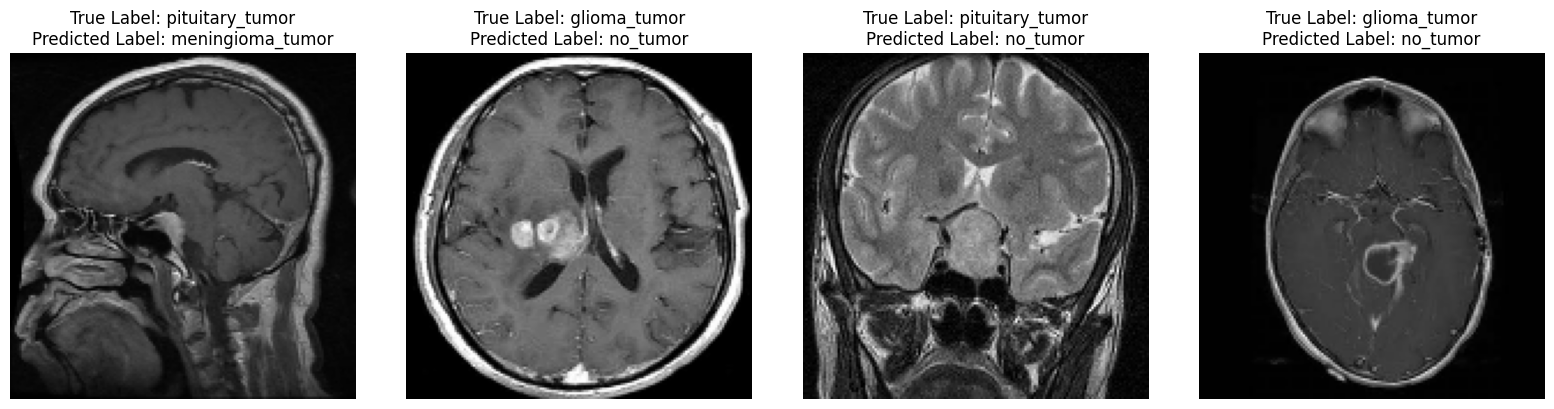

accuracy: 0.7690355329949239
Precision: 0.8429941474136169
Recall: 0.7631639247943596
F1-score: 0.7266171887095543


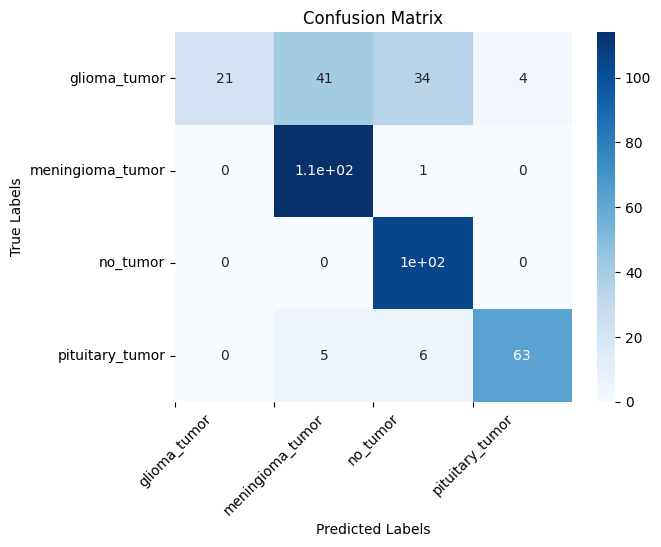

In [ ]:
# Change it to your own PATH

predict_testing_set("/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_augmented.h5")

## **Baseline Model: CNN with Stacked Edge Detection**




In [ ]:
#Exploring Edge Detection Techniques

def canny_edge(image):
  img = image.astype(np.uint8)
  # Blur image for better detection
  img = cv2.GaussianBlur(img, (3,3), 0)
  # Canny Edge Detection
  edges = cv2.Canny(img, threshold1=50, threshold2=300)
  canny_norm = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  return canny_norm


def sobel_edge(image):
    image = cv2.GaussianBlur(image, (3,3), 0)

    # Apply Sobel in the x and y directions
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute combined gradients
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize the gradient magnitude
    gradient_norm = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    return  gradient_norm


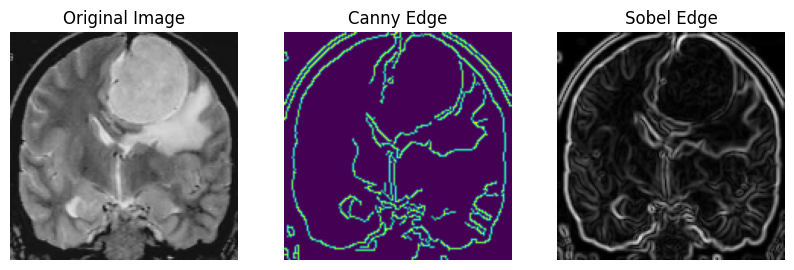

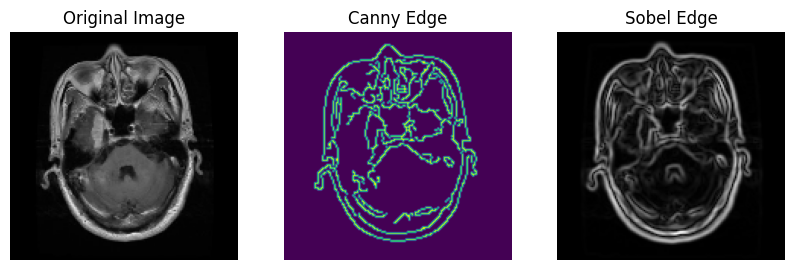

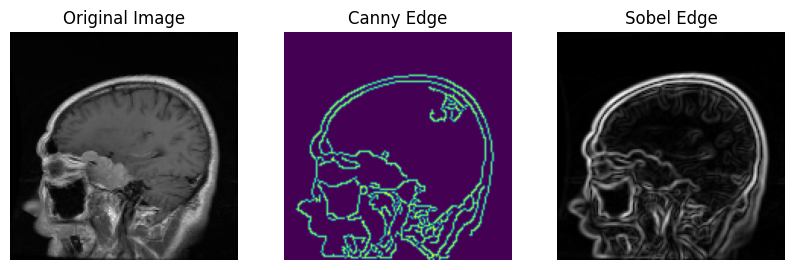

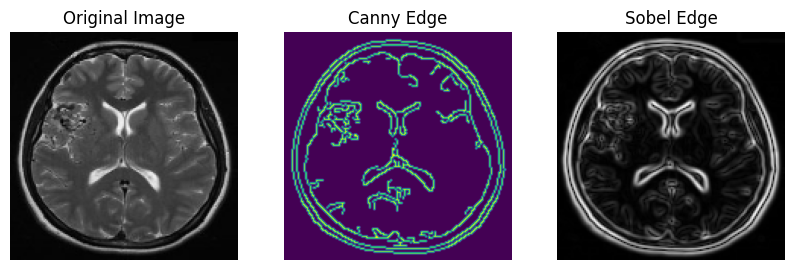

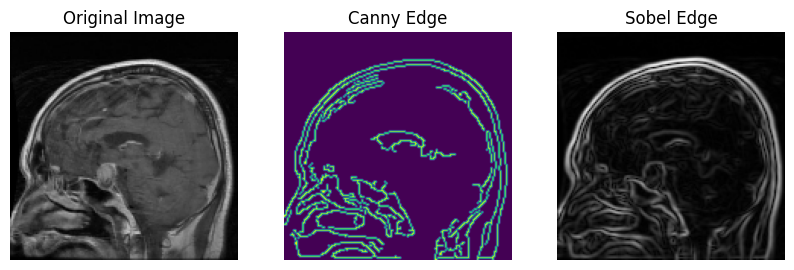

In [ ]:
#Visualize the edges
train_img, train_label = braintumor_train_ds.get_images()

for i in range (5):

  img = train_img[i]
  fig, axs = plt.subplots(1, 3, figsize=(10, 5))

  canny_edges = canny_edge(img)
  sobel_edges = sobel_edge(img)

  axs[0].imshow(train_img[i].astype(np.uint8), cmap='gray')
  axs[0].set_title('Original Image')

  axs[1].imshow(canny_edges, interpolation='gaussian')
  axs[1].set_title('Canny Edge')

  axs[2].imshow(sobel_edges, cmap='gray')
  axs[2].set_title('Sobel Edge')

  for ax in axs:
      ax.axis('off')

  plt.show()

In [ ]:
#stack the images on different dimensions
train_img, train_label = braintumor_train_ds.get_images()

edge_detected_images = []

for i in range(len(train_img)):
  # Generate the edges
  img = train_img[i]
  canny_edges = canny_edge(img)
  sobel_edges = sobel_edge(img)

  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_sobel =  cv2.cvtColor(sobel_edges, cv2.COLOR_BGR2GRAY)

  # Expand dimensions to stack them later
  gray_img_expanded = np.expand_dims(gray_img, axis=-1)
  canny_edges_expanded = np.expand_dims(canny_edges, axis=-1)
  sobel_edges_expanded = np.expand_dims(gray_sobel, axis=-1)

  # Stack the images onto different dimensions
  stacked_image = np.dstack((gray_img_expanded, canny_edges_expanded, sobel_edges_expanded))

  edge_detected_images.append(stacked_image)



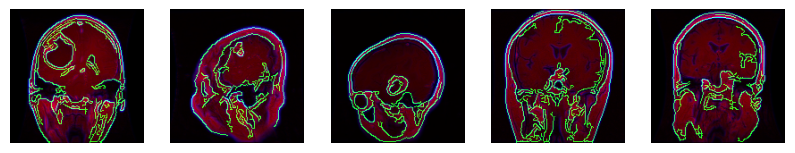

In [ ]:
# Visualising the stacked images
fig, axs = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    axs[i].imshow( edge_detected_images[i].astype(np.uint8))

for ax in axs:
    ax.axis('off')

plt.show()


In [ ]:
# train with the same CNN architecture before
## Change it to your own PATH

# Natcha Save Path
BASELINE_MODEL_STACKED_SAVE_PATH = "/content/drive/MyDrive/baseline_model_stacked.h5"
BASELINE_MODEL_STACKED_LOAD_PATH = "/content/drive/MyDrive/baseline_model_stacked.h5"

# # Josiah Save Path
# BASELINE_MODEL_STACKED_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_stacked.h5"
# BASELINE_MODEL_STACKED_LOAD_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_stacked.h5"


x_train = np.array(edge_detected_images)
y_train = np.array(train_label)

baseline_model_stacked, loss = model_setup()

#train with 30 epochs
model_train(baseline_model_stacked, x_train, y_train, loss, num_epochs=30,save_interval=1,save_path=BASELINE_MODEL_STACKED_SAVE_PATH, load_path=None)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 87s 794ms/step - loss: 1.5419
Epoch 2/30
90/90 [==============================] - 84s 941ms/step - loss: 0.9691
Epoch 3/30
90/90 [==============================] - 72s 801ms/step - loss: 0.7869
Epoch 4/30
90/90 [==============================] - 86s 961ms/step - loss: 0.6557
Epoch 5/30
90/90 [==============================] - 80s 892ms/step - loss: 0.5860
Epoch 6/30
90/90 [==============================] - 78s 874ms/step - loss: 0.5074
Epoch 7/30
90/90 [==============================] - 78s 871ms/step - loss: 0.4395
Epoch 8/30
90/90 [==============================] - 78s 873ms/step - loss: 0.3631
Epoch 9/30
90/90 [==============================] - 86s 959ms/step - loss: 0.2989
Epoch 10/30
90/90 [==============================] - 85s 909ms/step - loss: 0.2459
Epoch 11/30
90/90 [==============================] - 76s 846ms/step - loss: 0.2118
Epoch 12/30
90/90 [==============================] - 79s 880ms/step - loss: 0.2329
Epoch 13/30
90/90 [=====

In [ ]:
# Process the test set using the same method as before
test_img, test_label = braintumor_test_ds.get_images()

test_processed = []

for i in range(len(test_img)):
  img = test_img[i]
  canny_edges = canny_edge(img)
  sobel_edges = sobel_edge(img)

  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_sobel =  cv2.cvtColor(sobel_edges, cv2.COLOR_BGR2GRAY)

  gray_img_expanded = np.expand_dims(gray_img, axis=-1)
  canny_edges_expanded = np.expand_dims(canny_edges, axis=-1)
  sobel_edges_expanded = np.expand_dims(gray_sobel, axis=-1)

  stacked_image = np.dstack((gray_img_expanded, canny_edges_expanded, sobel_edges_expanded))

  test_processed.append(stacked_image)



13/13 [==============================] - 0s 6ms/step
accuracy: 0.7588832487309645
Precision: 0.8379281443678435
Recall: 0.7546944770857815
F1-score: 0.7129527107122297


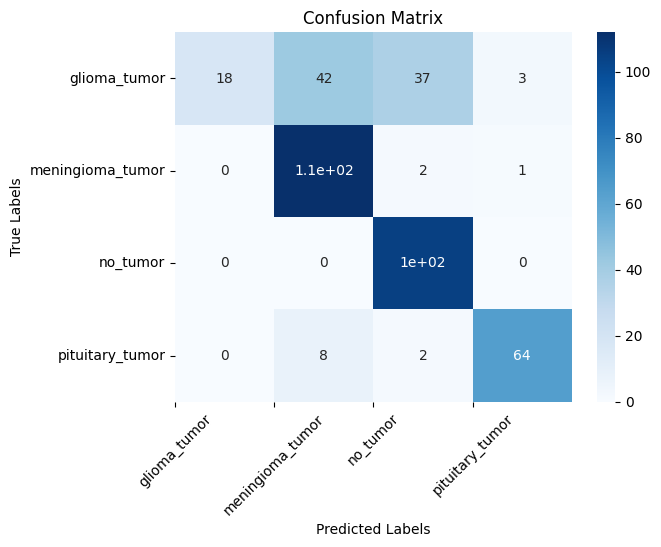

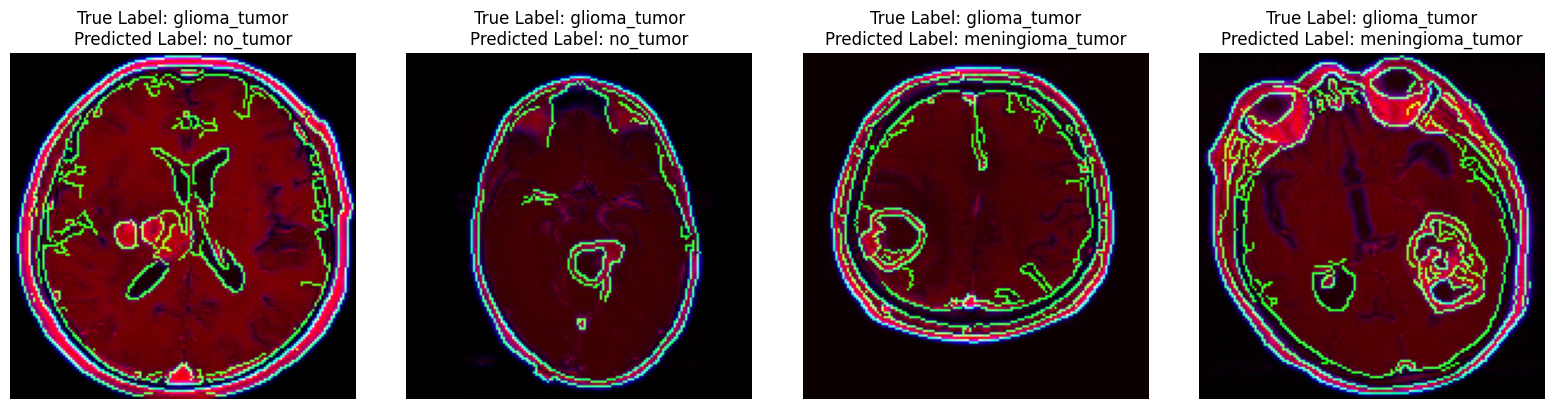

In [ ]:
#The test set for this model has to be processed first


model1 = load_model('/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/baseline_model_stacked.h5')

class_labels = braintumor_train_ds.classes

predictions = model1.predict(np.array(test_processed))

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_label, axis=1)

show_metrics(class_labels, true_labels, predicted_labels)

show_mislabeled_images(test_processed, true_labels, predicted_labels, class_labels, 4)




## **Model 2: Resnet Pretrained Model**



In [ ]:
def resnet_pretrained(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape,classes= num_classes)

    for layer in base_model.layers[:-5]:
      layer.trainable = True

    #use ResNet as base and build on top of it

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=num_classes, activation='softmax')
    ])



    return model

In [ ]:
def resnet_model_setup(LOAD_PATH=None):
  INPUT_SHAPE = (150, 150, 3)
  NUM_CLASSES = len(braintumor_train_ds.classes)

  # Build model
  model = resnet_pretrained(INPUT_SHAPE, NUM_CLASSES)

  # Use categorical cross entropy loss
  loss_fn = tf.keras.losses.CategoricalCrossentropy()

  if LOAD_PATH:
      model.load_weights(LOAD_PATH)

  return model, loss_fn

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24113284 (91.98 MB)
Trainable params: 24060164 (91.78 MB)
Non-trainable params: 53120 (207.50 KB)
________

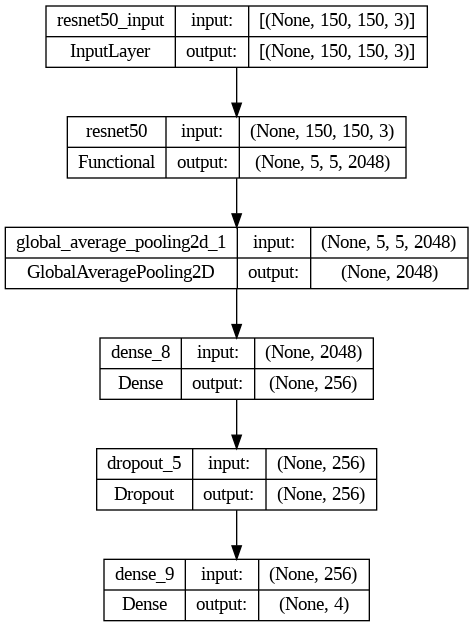

In [ ]:
resnet_model, loss = resnet_model_setup()
# Print model summary and plot
resnet_model.summary()

plot_model(resnet_model, to_file='/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/resnet_model.png', show_shapes=True)

In [ ]:
# Change it to your own PATH

RESNET_MODEL_SAVE_PATH = "/content/drive/MyDrive/resnet_model.h5"
#RESNET_MODEL_LOAD_PATH = "/content/drive/MyDrive/resnet_model.h5"

#RESNET_MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/resnet_model.h5"
#RESNET_MODEL_LOAD_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/resnet_model.h5"

model_train(resnet_model, new_augmented_train_images, new_augmented_train_labels , loss, num_epochs = 20, save_interval=1, save_path= RESNET_MODEL_SAVE_PATH , load_path=None)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 210s 2s/step - loss: 0.9450
Epoch 2/20
90/90 [==============================] - 166s 2s/step - loss: 0.4534
Epoch 3/20
90/90 [==============================] - 168s 2s/step - loss: 0.3221
Epoch 4/20
90/90 [==============================] - 171s 2s/step - loss: 0.2455
Epoch 5/20
90/90 [==============================] - 169s 2s/step - loss: 0.1745
Epoch 6/20
90/90 [==============================] - 171s 2s/step - loss: 0.1518
Epoch 7/20
90/90 [==============================] - 167s 2s/step - loss: 0.1335
Epoch 8/20
90/90 [==============================] - 169s 2s/step - loss: 0.1119
Epoch 9/20
90/90 [==============================] - 170s 2s/step - loss: 0.0751
Epoch 10/20
90/90 [==============================] - 173s 2s/step - loss: 0.0913
Epoch 11/20
90/90 [==============================] - 166s 2s/step - loss: 0.0567
Epoch 12/20
90/90 [==============================] - 166s 2s/step - loss: 0.0670
Epoch 13/20
90/90 [=============================

In [ ]:
# Change it to your own PATH

resnet_model.save("/content/drive/MyDrive/resnet_model_01.h5")


13/13 [==============================] - 1s 13ms/step


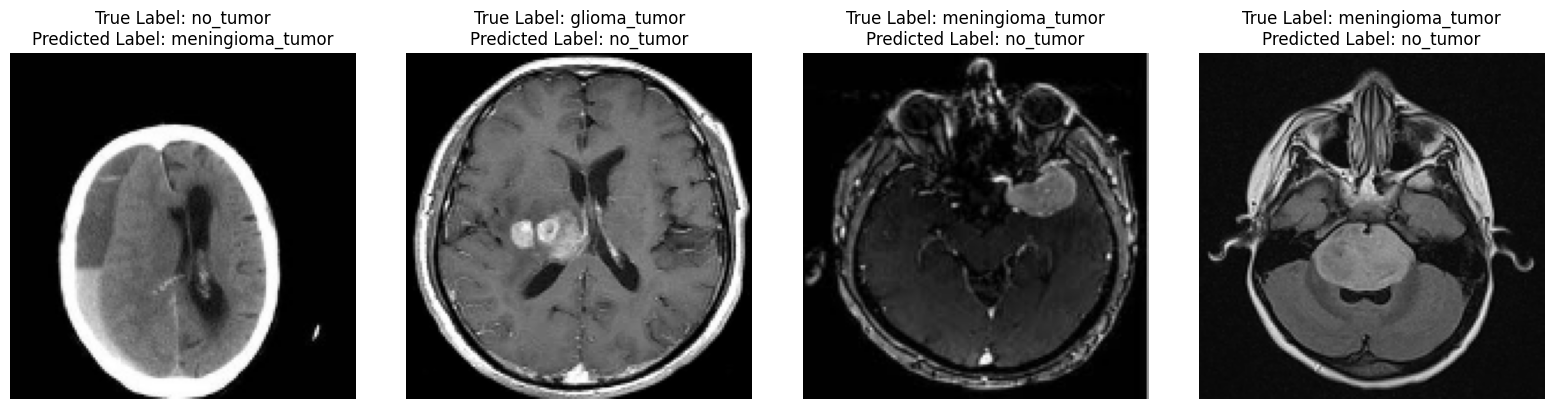

accuracy: 0.6751269035532995
Precision: 0.7634459316790143
Recall: 0.6538913603044038
F1-score: 0.6190826350089939


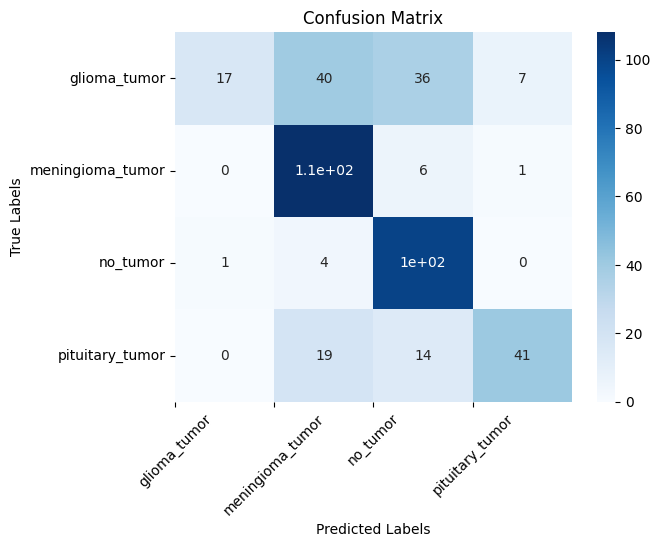

In [ ]:
# Change it to your own PATH

predict_testing_set("/content/drive/MyDrive/Colab Notebooks/COMP 4211/COMP4211 Project/resnet_model_01.h5")

## **Model 3: Random Forest Tree: Data Augmentation**



In [ ]:
#Process to greyscale for Random Forest and SVM

train_images, train_labels = braintumor_train_ds.get_greyscaled_images()
original_test_images, test_labels = braintumor_test_ds.get_greyscaled_images()

prepare_images = np.expand_dims(train_images, axis=-1)  # Add an extra dimension for the channel

augmented_images = []
augmented_labels = []

for i in range(len(prepare_images)):
  image, label = datagen.flow(x = prepare_images[i:i+1], y=train_labels[i:i+1], shuffle=False, batch_size = 1).next()
  augmented_images.append(image[0])
  augmented_labels.append(label[0])


augmented_train_images = np.concatenate((prepare_images, augmented_images), axis=0)
augmented_train_labels = np.concatenate((train_labels, augmented_labels), axis=0)


# For Random Forest Tree and SVC, we need to flatten the images to 2D
test_images = original_test_images.reshape(len(original_test_images),-1)
augmented_images = augmented_train_images.reshape(len(augmented_train_images),-1)

(284, 324)
(512, 512)
(512, 512)
(286, 224)
(512, 512)
(231, 236)
(512, 512)
(512, 512)
(223, 229)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(213, 210)
(512, 512)
(512, 512)
(512, 512)
(630, 630)
(512, 512)
(512, 512)
(380, 336)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(216, 236)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(328, 267)
(512, 512)
(512, 512)
(512, 512)
(993, 825)
(512, 512)
(210, 233)
(512, 512)
(512, 512)
(256, 256)
(512, 512)
(512, 512)
(512, 512)
(251, 201)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(412, 300)
(396, 411)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(223, 226)
(512, 512)
(275, 220)
(512, 512)
(234, 216)
(512, 512)
(210, 201)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 434)

In [ ]:
# Fit the Random Forest model
class_labels = braintumor_test_ds.classes

rf = RandomForestClassifier(n_estimators=100, random_state=4211)
labels = np.argmax(augmented_train_labels,axis=1)


rf.fit(augmented_images, labels)


accuracy: 0.7461928934010152
Precision: 0.8025662356625487
Recall: 0.7334106933019977
F1-score: 0.7024572197905175


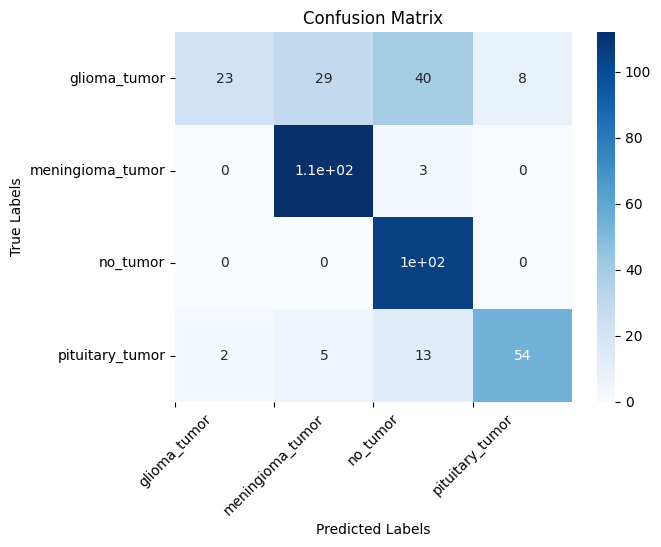

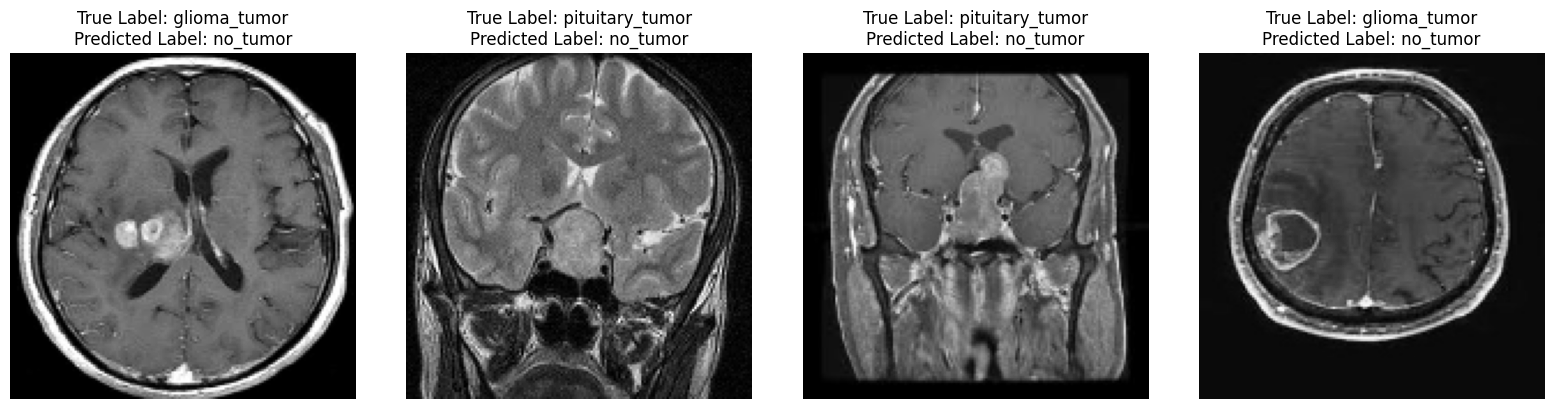

In [ ]:
#Show metrics for Random Forest

predicted_labels = rf.predict(test_images)

true_labels = np.argmax(test_labels , axis=1)

show_metrics(class_labels, true_labels, predicted_labels)
show_mislabeled_images(original_test_images, true_labels, predicted_labels, class_labels, num_images=4)

## **Model 4: SVM: Data Augmentation**




In [ ]:
# Fit the SVM model

svm = SVC(kernel='rbf')

labels = np.argmax(augmented_train_labels,axis=1)

svm.fit(augmented_images, labels)


accuracy: 0.6421319796954315
Precision: 0.6456511988959808
Recall: 0.6235409322365844
F1-score: 0.5971184555502436


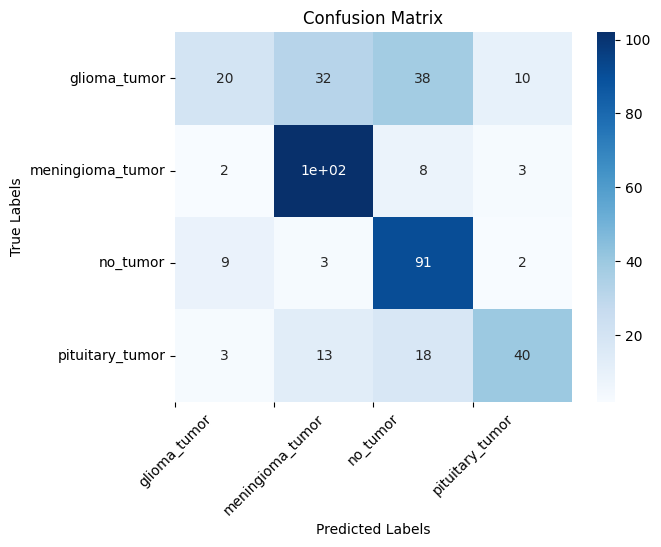

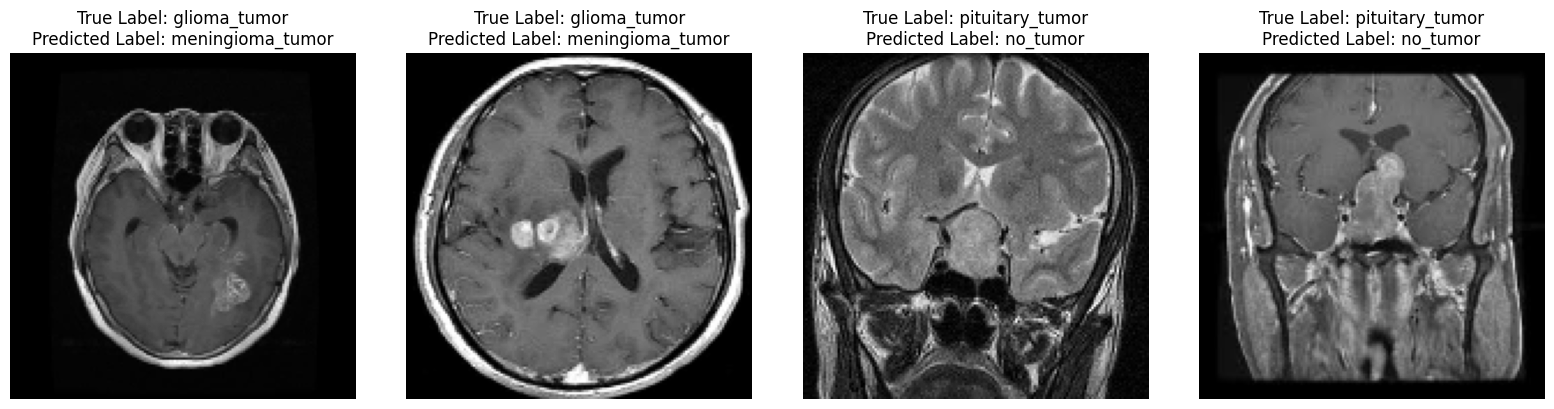

In [ ]:
#Show metrics for SVM

predicted_labels = svm.predict(test_images)
true_labels = np.argmax(test_labels , axis=1)

show_metrics(class_labels, true_labels, predicted_labels)
show_mislabeled_images(original_test_images, true_labels, predicted_labels, class_labels, num_images=4)

# Task #2: Image Segmentation

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)

<h3> Image Segmentation (Helper Functions)</h3>

In [ ]:
# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path):
    images = []
    masks = []

    for label in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, label)
        if (label == "images"):
          for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            images.append(file_path)
        else:
          for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            masks.append(file_path)

    return images, masks

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(128,128)):
    image = cv2.imread(img_path)
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    return image

def get_mask(img_path, resize=True, shape=(128,128)):
    image = cv2.imread(img_path,0)
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    return image

def prepare_images(images_path_list, masks_path_list):
  images = []
  masks = []
  for i in range(len(images_path_list)):
    image = get_image(images_path_list[i])
    mask = get_mask(masks_path_list[i])
    images.append(image)
    masks.append(mask)
  return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)

def convert_to_one_hot(binary_masks, num_classes):
    one_hot_masks = tf.one_hot(binary_masks, depth=num_classes)
    return one_hot_masks




<h4> Create binary masks as labels </h4>

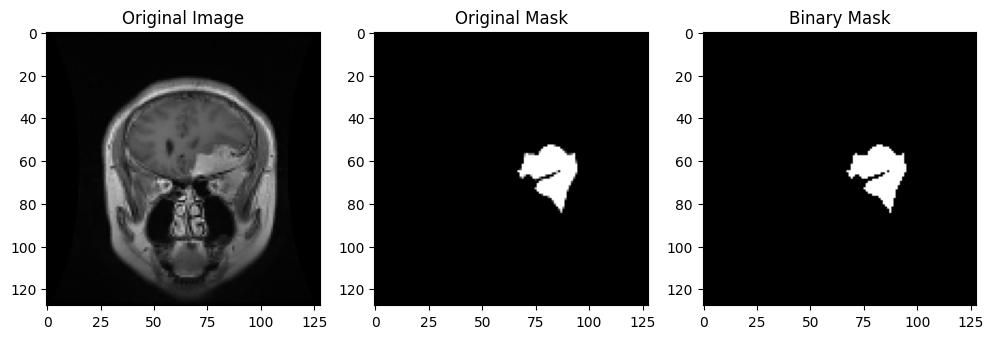

In [ ]:
segmentation_path = "segmentation_dataset/Segmentation_Training"
segmentation_training_path = "segmentation_dataset/Segmentation_Testing"

images, masks = find_images(segmentation_path)

test_images, test_masks= find_images(segmentation_training_path)

# Sort the Pairs
images.sort()
masks.sort()

test_images.sort()
test_masks.sort()

images, masks = prepare_images(images, masks)

test_images, test_masks = prepare_images(test_images, test_masks)

binary_masks = np.where(masks > 150, 1, 0)

binary_test_masks = np.where(test_masks > 150, 1, 0)


# Display the original mask

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(images[0].astype(np.uint8), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(masks[0], cmap='gray')
plt.title('Original Mask')

# Display the binary mask
plt.subplot(1, 3, 3)
plt.imshow(binary_masks[0], cmap='gray')
plt.title('Binary Mask')

plt.show()

binary_train_masks = convert_to_one_hot(binary_masks,2)
binary_ground_truth_masks = convert_to_one_hot(binary_test_masks,2)


<h3> Build the U-Net Architecture </h3>

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
   return x

def encoder_block(x, n_filters):
   conv_features = double_conv_block(x, n_filters)

   pooled_features = layers.MaxPool2D(2)(conv_features)

   pooled_features = layers.Dropout(0.5)(pooled_features)
   return conv_features, pooled_features

def decoder_block(x, skip_conn_features, n_filters):
   # Upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # Concatenate skip connection features
   x = layers.concatenate([x, skip_conn_features])
   # Dropout
   x = layers.Dropout(0.5)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def build_unet_model():
   # Inputs
   inputs = layers.Input(shape=(128, 128, 3))

   # Encoder: Contracting Path - Downsample
   # 1 - Downsample
   conv1, pool1 = encoder_block(inputs, 64)
   # 2 - Downsample
   conv2, pool2 = encoder_block(pool1, 128)
   # 3 - Downsample
   conv3, pool3 = encoder_block(pool2, 256)
   # 4 - Downsample
   conv4, pool4 = encoder_block(pool3, 512)

   # Bottleneck
   bottleneck = double_conv_block(pool4, 1024)

   # Decoder: Expanding Path - Upsample

   # 6 - Upsample
   up6 = decoder_block(bottleneck, conv4, 512)
   # 7 - Upsample
   up7 = decoder_block(up6, conv3, 256)
   # 8 - Upsample
   up8 = decoder_block(up7, conv2, 128)
   # 9 - Upsample
   up9 = decoder_block(up8, conv1, 64)

   # Outputs
   outputs = layers.Conv2D(2, 1, padding="same", activation="softmax")(up9)

   # U-Net model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
#Display the U-net model

unet_model = build_unet_model()
unet_model.summary()
plot_model(unet_model, to_file='/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/unet_model_test.png', show_shapes=False)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 conv2d_77 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_76[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 64)           0         ['conv2d_77[0][0]']           
 ng2D)                                                                                        

In [ ]:
unet_model.fit(x=images, y=binary_train_masks, epochs = 150, shuffle=False)

Epoch 1/150
4/4 [==============================] - 6s 55ms/step - loss: 1.0471 - accuracy: 0.8463
Epoch 2/150
4/4 [==============================] - 0s 47ms/step - loss: 0.6191 - accuracy: 0.9846
Epoch 3/150
4/4 [==============================] - 0s 47ms/step - loss: 0.3442 - accuracy: 0.9777
Epoch 4/150
4/4 [==============================] - 0s 48ms/step - loss: 0.2886 - accuracy: 0.9807
Epoch 5/150
4/4 [==============================] - 0s 47ms/step - loss: 0.2132 - accuracy: 0.9846
Epoch 6/150
4/4 [==============================] - 0s 48ms/step - loss: 0.1960 - accuracy: 0.9833
Epoch 7/150
4/4 [==============================] - 0s 52ms/step - loss: 0.1579 - accuracy: 0.9846
Epoch 8/150
4/4 [==============================] - 0s 48ms/step - loss: 0.0928 - accuracy: 0.9846
Epoch 9/150
4/4 [==============================] - 0s 47ms/step - loss: 0.0920 - accuracy: 0.9846
Epoch 10/150
4/4 [==============================] - 0s 48ms/step - loss: 0.0793 - accuracy: 0.9846
Epoch 11/150
4/4 [=

In [ ]:
#Change it to your PATH

unet_model.save("/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/segment1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Change it to your PATH

unet_model.load_weights("/content/drive/My Drive/Colab Notebooks/COMP 4211/COMP4211 Project/segment1.h5")

Predicition for Segmentation for Images

(1, 128, 128, 3)
1/1 [==============================] - 0s 256ms/step
Dice Coefficient: 0.765133171912833


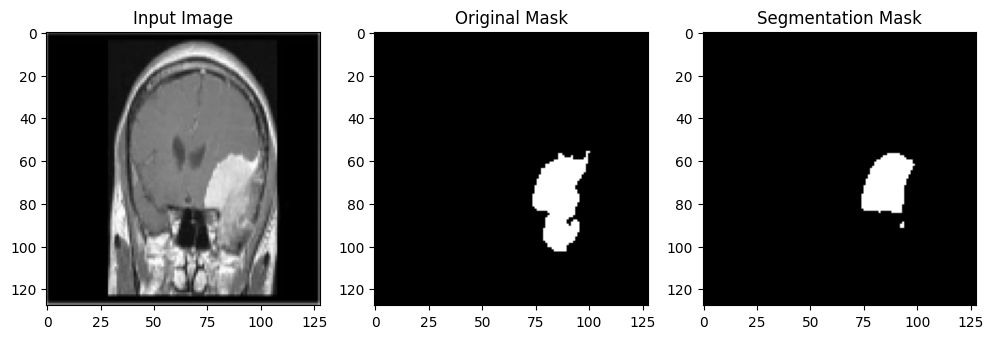

In [ ]:
input_image = get_image("segmentation_dataset/Segmentation_Testing/images/image(1).jpg")
input_image = np.expand_dims(input_image, axis=0)  # Add an extra dimension to represent the batch size
print(input_image.shape)

# Make prediction
prediction = unet_model.predict(input_image)

# If you are performing binary segmentation (num_classes = 2), apply thresholding
threshold_prediction = np.argmax(prediction[0], axis=-1)

# Calculate Dice coefficient
dice_coefficient = f1_score(binary_test_masks[0].flatten(),threshold_prediction.flatten(), average='binary')
# Print the Dice coefficient
print("Dice Coefficient:", dice_coefficient)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_image[0], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_test_masks[0], cmap='gray')
plt.title('Original Mask')

# Display the binary mask
plt.subplot(1, 3, 3)
plt.imshow(threshold_prediction, cmap='gray')  # Use 'cmap='gray'' for binary masks
plt.title('Segmentation Mask')

# Display the plot
plt.show()

(1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
Dice Coefficient: 0.4897788902795161


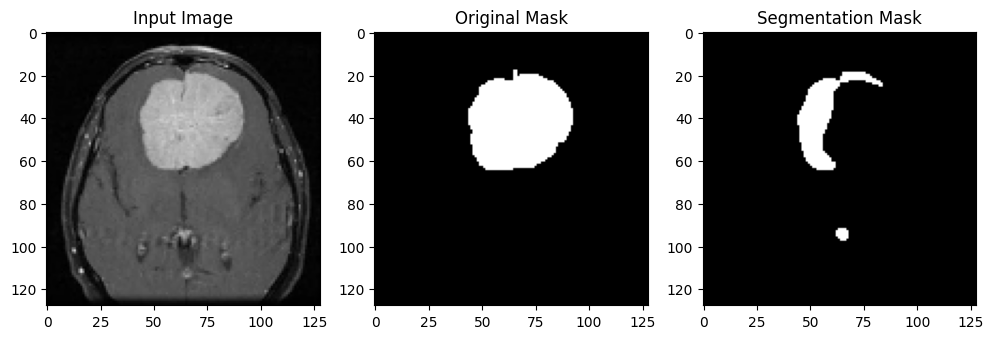

In [ ]:
input_image = get_image("segmentation_dataset/Segmentation_Testing/images/image(2).jpg")
input_image = np.expand_dims(input_image, axis=0)  # Add an extra dimension to represent the batch size
print(input_image.shape)

# Make prediction
prediction = unet_model.predict(input_image)

# If you are performing binary segmentation (num_classes = 2), apply thresholding
threshold_prediction = np.argmax(prediction[0], axis=-1)

# Calculate Dice coefficient
dice_coefficient = f1_score(binary_test_masks[1].flatten(),threshold_prediction.flatten(), average='binary')
# Print the Dice coefficient
print("Dice Coefficient:", dice_coefficient)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_image[0], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_test_masks[1], cmap='gray')
plt.title('Original Mask')

# Display the binary mask
plt.subplot(1, 3, 3)
plt.imshow(threshold_prediction, cmap='gray')  # Use 'cmap='gray'' for binary masks
plt.title('Segmentation Mask')

# Display the plot
plt.show()

(1, 128, 128, 3)
1/1 [==============================] - 0s 24ms/step
Dice Coefficient: 0.6845425867507887


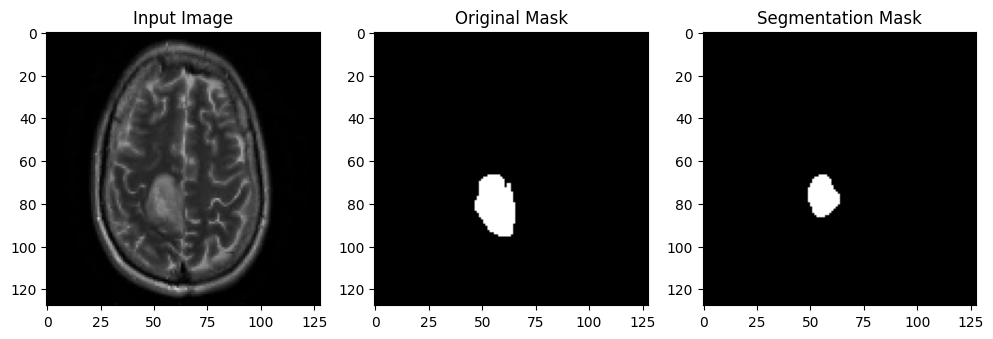

In [ ]:
input_image = get_image("segmentation_dataset/Segmentation_Testing/images/image(3).jpg")
input_image = np.expand_dims(input_image, axis=0)  # Add an extra dimension to represent the batch size
print(input_image.shape)

# Make prediction
prediction = unet_model.predict(input_image)

# If you are performing binary segmentation (num_classes = 2), apply thresholding
threshold_prediction = np.argmax(prediction[0], axis=-1)

# Calculate Dice coefficient
dice_coefficient = f1_score(binary_test_masks[2].flatten(),threshold_prediction.flatten(), average='binary')
# Print the Dice coefficient
print("Dice Coefficient:", dice_coefficient)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_image[0], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_test_masks[2], cmap='gray')
plt.title('Original Mask')

# Display the binary mask
plt.subplot(1, 3, 3)
plt.imshow(threshold_prediction, cmap='gray')  # Use 'cmap='gray'' for binary masks
plt.title('Segmentation Mask')

# Display the plot
plt.show()

(1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
Dice Coefficient: 0.891820580474934


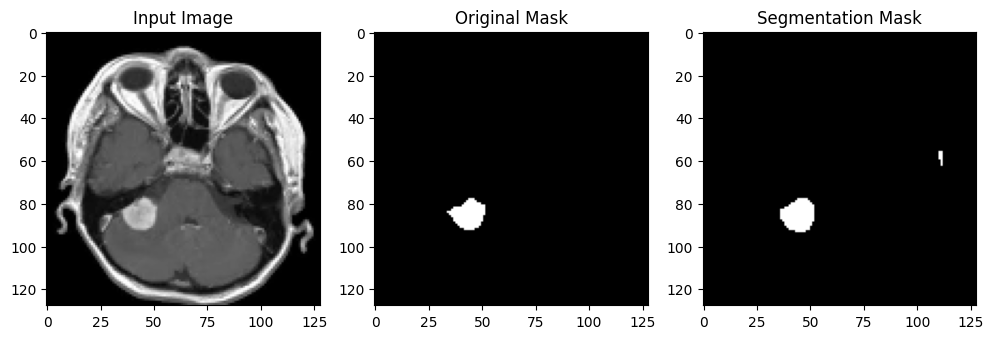

In [ ]:
input_image = get_image("segmentation_dataset/Segmentation_Testing/images/image(4).jpg")
input_image = np.expand_dims(input_image, axis=0)  # Add an extra dimension to represent the batch size
print(input_image.shape)

# Make prediction
prediction = unet_model.predict(input_image)

# If you are performing binary segmentation (num_classes = 2), apply thresholding
threshold_prediction = np.argmax(prediction[0], axis=-1)

# Calculate Dice coefficient
dice_coefficient = f1_score(binary_test_masks[3].flatten(),threshold_prediction.flatten(), average='binary')
# Print the Dice coefficient
print("Dice Coefficient:", dice_coefficient)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_image[0], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_test_masks[3], cmap='gray')
plt.title('Original Mask')

# Display the binary mask
plt.subplot(1, 3, 3)
plt.imshow(threshold_prediction, cmap='gray')  # Use 'cmap='gray'' for binary masks
plt.title('Segmentation Mask')

# Display the plot
plt.show()

(1, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step
Dice Coefficient: 0.1768060836501901


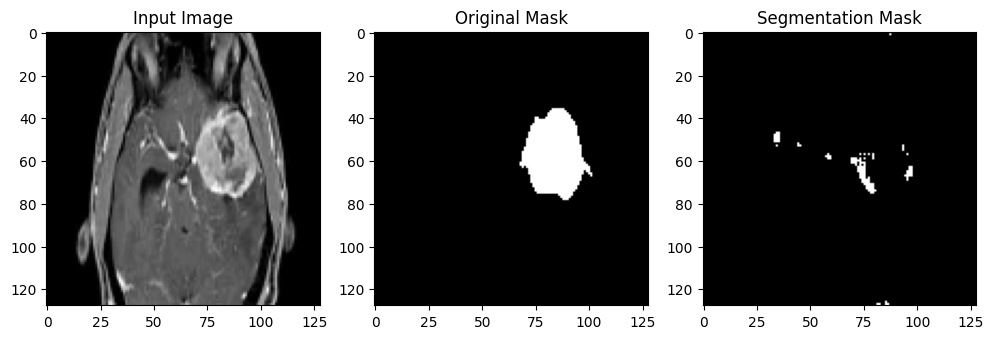

In [ ]:
input_image = get_image("segmentation_dataset/Segmentation_Testing/images/image(5).jpg")
input_image = np.expand_dims(input_image, axis=0)  # Add an extra dimension to represent the batch size
print(input_image.shape)

# Make prediction
prediction = unet_model.predict(input_image)

# If you are performing binary segmentation (num_classes = 2), apply thresholding
threshold_prediction = np.argmax(prediction[0], axis=-1)

# Calculate Dice coefficient
dice_coefficient = f1_score(binary_test_masks[4].flatten(),threshold_prediction.flatten(), average='binary')
# Print the Dice coefficient
print("Dice Coefficient:", dice_coefficient)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_image[0], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_test_masks[4], cmap='gray')
plt.title('Original Mask')

# Display the binary mask
plt.subplot(1, 3, 3)
plt.imshow(threshold_prediction, cmap='gray')  # Use 'cmap='gray'' for binary masks
plt.title('Segmentation Mask')

# Display the plot
plt.show()